# Graficas y tablas
Este jupyter notebook tiene como objetivo generar las tablas y gráficas a partir 
de los datos obtenidos en la ejecución de las distintas configuraciones.

## Inicializaciones

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

A partir de los datos obtenidos en cada configuración, se fusionan en un único fichero por configuración.

In [2]:
import subprocess

sequential_folder = "./data/Sequential"
mpi_folder = "./data/MPI" 
omp_folder = "./data/OpenMP"
mpi_openmp_folder = "./data/MPI+OpenMP"

csv_name = "/joinedData.csv"
join_data_script = "/joinData.py"

# Execute the joinData.py script from the forlders inside the data folder
# to generate the data.csv file
subprocess.run(["python3", sequential_folder + join_data_script], check=True)
subprocess.run(["python3", mpi_folder + join_data_script], check=True)
subprocess.run(["python3", omp_folder + join_data_script], check=True)
subprocess.run(["python3", mpi_openmp_folder + join_data_script], check=True)


[OK] OpenMP data joined successfully
[OK] MPI data joined successfully
[OK] OpenMP data joined successfully
[OK] MPI + OpenMP data joined successfully


CompletedProcess(args=['python3', './data/MPI+OpenMP/joinData.py'], returncode=0)

In [3]:
sequential_data = pd.read_csv(sequential_folder + csv_name)
mpi_data = pd.read_csv(mpi_folder + csv_name)
openmp_data = pd.read_csv(omp_folder + csv_name)
mpi_openmp_data = pd.read_csv(mpi_openmp_folder + csv_name)

A continuación se definen varias funciones para la generación de las tablas y gráficas.

In [4]:
tables_path = "./results_assets/tables/"
def save_csv(data, name):
    try:
        if not os.path.exists(tables_path):
            os.makedirs(tables_path)
        data.to_csv(name+".csv", index=False)
        print("\033[92m" + "[OK]" + "\033[0m" + " Table saved as " + name + ".csv")
    except:
        print("\033[91m" + "[ERROR]" + "\033[0m" + " Error saving table as " + name + ".csv")


In [5]:
def show_accumulative_plot(data, title, horizontal=False, data_per_graph=10):
    partial_columns = [
        'ReadGray(s)', 'ReadColor(s)', 'Gray(s)', 'Hsl(s)', 'Yuv(s)', 
        'WriteGray(s)', 'WriteHsl(s)', 'WriteYuv(s)'
    ]

    data = data.sort_values(by='Total(s)', ascending=True).head(data_per_graph).sort_values(by='Total(s)', ascending=False)

    data_partial = data[partial_columns].copy()

    # Add the Rest (s) column, with min value o 0
    data_partial.loc[:, 'Rest(s)'] = (data['Total(s)'] - data_partial.sum(axis=1)).clip(lower=0)

    # Transpose for plotting
    data_for_plot = data_partial
    labels = partial_columns + ['Rest(s)']

    # Create the stacked bar plot

    plt.figure(figsize=(5, 5))

    print(len(labels))

    if horizontal:
        ax = data_for_plot.plot(kind='barh', stacked=True, figsize=(12, len(labels)*0.6), colormap='viridis')
        plt.xlabel('Segundos', fontsize=12)
        plt.ylabel('Configuración', fontsize=12)
        plt.yticks(ticks=range(len(data)), labels=data['Label'])
    else:
        ax = data_for_plot.plot(kind='bar', stacked=True, figsize=(12, 8), colormap='viridis')
        plt.ylabel('Segundos', fontsize=12)
        plt.xlabel('Configuración', fontsize=12)
        plt.xticks(ticks=range(len(data)), labels=data['Label'], rotation=45)

    # Customize the plot
    plt.title(title or 'Accumulative Bar Chart of the 5 Best Times', fontsize=16)
    plt.legend(labels, title='Categories', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()

    # Add total time at the top of each bar
    for i, total in enumerate(data['Total(s)']):
        if horizontal:
            ax.text(total, i, f'{total:.2f}', ha='left', va='center')
        else:
            ax.text(i, total, f'{total:.2f}', ha='center', va='bottom')

    # Save the plot
    plt.savefig('results_assets/figures/' + title or 'Accumulative Bar Chart of the 5 Best Times' + '.png')

    # Show the plot
    plt.show()


def show_bar_plot (labels, data, title, horizontal=False):
    # Plot the bar chart horizontally
    plt.figure(figsize=(12, 6))
    bars = plt.barh(labels, data)
    plt.ylabel('Configuración')
    plt.xlabel('Tiempo total (s)')
    plt.title(title or 'Total Time of the 5 Best Configurations', fontsize=16)

    # Add the value in each bar
    for bar in bars:
        plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{bar.get_width():.2f}', 
                 va='center', ha='left', fontsize=10)

    plt.tight_layout()


    # Save the plot
    plt.savefig('results_assets/figures/' + title or 'Total Time of the 5 Best Configurations' + '.png')

    plt.show()

def draw_grouped_bar_chart(data, column1, column2, column3, title):
    nodes = data[column1].unique()
    processes = data[column2].unique()

    aux={}


    for p in processes:
        values = list()
        for n in nodes:
            node_data = data[data[column1]==n]
            
            try:
                value = float(node_data[node_data[column2]==p][column3])
            except: value=0

            values.append(round(value,2))

        aux[p] = values

    

    x = np.arange(len(nodes))  # Posiciones de los nodos
    width = 0.15  # Ancho de las barras
    multiplier = 0  # Variable para crear el desplazamiento de las barras
    colors = plt.cm.tab20(np.linspace(0, 1, len(processes)))  # Colores para las barras

    fig, ax = plt.subplots(figsize=(10, 6), layout='constrained')

    # Loop para crear las barras para cada proceso
    for process, v in aux.items():
        offset = width * multiplier  # Desplazamiento para las barras
        rects = ax.bar(x + offset, v, width, label=f"{process}", color=colors[multiplier % len(processes)])
        ax.bar_label(rects, padding=8, fontsize=7, color='black')  # Etiquetas con mejor visibilidad
        multiplier += 1  # Aumentamos el desplazamiento para la siguiente barra

    # Ajustes de formato
    
    ax.set_ylabel(column3, fontsize=12)
    ax.set_xlabel(column1, fontsize=12)
    ax.set_title(title, fontsize=14)
    ax.set_xticks(x + width * 2)  # Ajustamos los ticks para que estén en el medio de las barras
    ax.set_xticklabels(nodes, fontsize=12)
    ax.legend(title=column2, loc='upper right', ncol=3, fontsize=10, frameon=False)  # Mejorando la leyenda
    ax.set_ylim(0, 50)  # Establecemos el límite superior del eje Y
    
    # Mejorar la visualización general
    plt.grid(axis='y', linestyle='--', alpha=0.7)  # Añadimos una cuadrícula
    plt.tight_layout()
    plt.savefig('results_assets/figures/' + title or 'Accumulative Bar Chart of the 5 Best Times' + '.png')
    # Mostrar el gráfico
    plt.show()
    


## General

En esta sección vamos a generar las tablas y gráficas para el análisis general de resultados.

9


<Figure size 500x500 with 0 Axes>

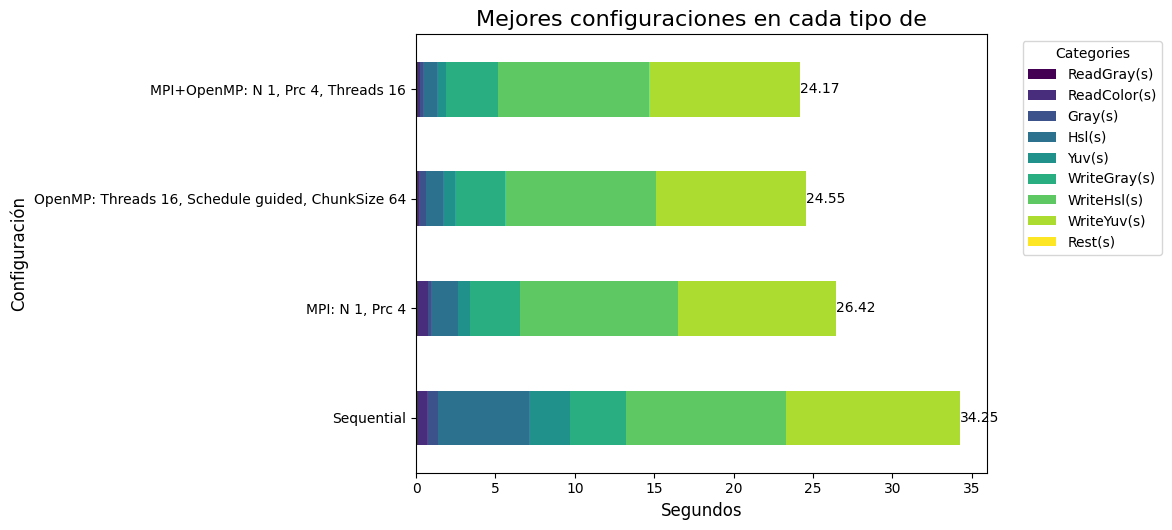

In [6]:
num_top_times = 1

# Extract the best times from openmp_data
best_openmp_times = openmp_data.nsmallest(num_top_times, 'Total(s)')

# Extract the best times from mpi_data
best_mpi_times = mpi_data.nsmallest(num_top_times, 'Total(s)')

# Extract the best times from mpi_openmp_data
best_mpi_openmp_times = mpi_openmp_data.nsmallest(num_top_times, 'Total(s)')

# Mix the best times from mpi, openmp and mpi+openmp
best_times = pd.concat([best_mpi_times, best_openmp_times, best_mpi_openmp_times, sequential_data], ignore_index=True)

# Order in descending order
best_times = best_times.sort_values(by='Total(s)', ascending=False)

show_accumulative_plot(best_times, 'Mejores configuraciones en cada tipo de', True)

In [7]:
partial_columns = [
    'ReadGray(s)', 'ReadColor(s)', 'Gray(s)', 'Hsl(s)', 'Yuv(s)', 
    'WriteGray(s)', 'WriteHsl(s)', 'WriteYuv(s)', 'Total(s)'
]

best_times_partial = best_times[partial_columns]

speedup = pd.DataFrame()
speedup['Label'] = best_times['Label']

def get_times(row):
    total = row['Total(s)']
    rest_time = total - row['ReadGray(s)'] - row['ReadColor(s)'] - row['Gray(s)'] - row['Hsl(s)'] - row['Yuv(s)'] - row['WriteGray(s)'] - row['WriteHsl(s)'] - row['WriteYuv(s)']
    secuential_time = row['ReadGray(s)'] + row['WriteGray(s)'] + rest_time
    parallel_time_with_threads = row['ReadColor(s)'] + row['WriteHsl(s)'] + row['WriteYuv(s)']
    parallel_time_with_threads_and_processes = row['Gray(s)'] + row['Hsl(s)'] + row['Yuv(s)']

    return (secuential_time/total).values[0], (parallel_time_with_threads/total).values[0], (parallel_time_with_threads_and_processes/total).values[0]

def get_amdahls_speedup(processes = 1, threads = 1):
    secuential_row = best_times.loc[best_times['Label'] == 'Sequential']
    secuential_time_percentage, parallel_time_with_threads_percentage, parallel_time_with_threads_and_processes_percentage = get_times(secuential_row)

    # Calculate the speedup
    speedup = 1 / (secuential_time_percentage + 
                       (parallel_time_with_threads_percentage) / (processes*threads) + 
                       (parallel_time_with_threads_and_processes_percentage) / threads)

    return speedup

for column in partial_columns:
    speedup[column] = best_times.loc[best_times['Label'] == 'Sequential', column].values[0] / best_times[column]

# For each row, calculate the speedup and add it to the speedup dataframe
for index, row in best_times.iterrows():
    processes = row['Processes'] if not np.isnan(row['Processes']) else 1
    threads = row['Num Threads'] if not np.isnan(row['Num Threads']) else 1

    amdhal_speedup = get_amdahls_speedup(processes, threads)
    speedup.loc[index, 'Amdhal'] = amdhal_speedup

    original_row = best_times.loc[best_times['Label'] == row['Label']]

# Round to 4 decimal places
speedup = speedup.round(4)
speedup.columns = speedup.columns.str.replace(r'\(s\)', '', regex=True)

# Save the speedup table
save_csv(speedup, tables_path + "speedup")

speedup



[OK] Table saved as ./results_assets/tables/speedup.csv


,Label,ReadGray,ReadColor,Gray,Hsl,Yuv,WriteGray,WriteHsl,WriteYuv,Total,Amdhal
3,Sequential,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.000,1.0000,1.0000,1.0000
0,"MPI: N 1, Prc 4",0.7113,0.9309,3.1331,3.4546,3.3750,1.1078,1.019,1.0997,1.2964,1.9043
1,"OpenMP: Threads 16, Schedule guided, ChunkSize 64",0.9218,3.5696,1.7490,5.2515,3.6183,1.0989,1.067,1.1561,1.3953,6.2673
2,"MPI+OpenMP: N 1, Prc 4, Threads 16",0.6967,3.2277,3.9592,6.2953,4.7508,1.0664,1.065,1.1485,1.4174,7.6995


## MPI

9


<Figure size 500x500 with 0 Axes>

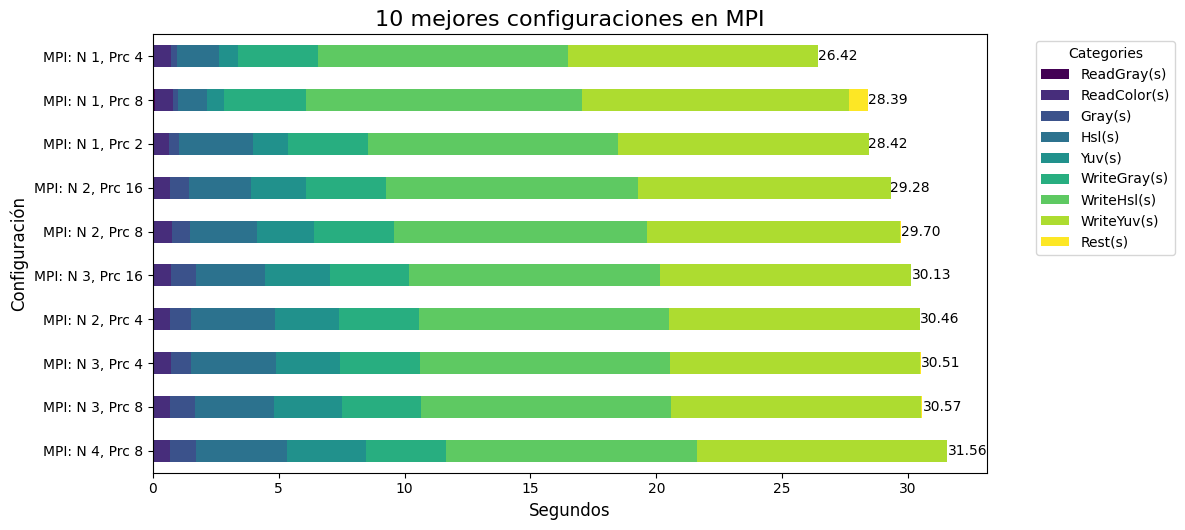

In [8]:
show_accumulative_plot(mpi_data, '10 mejores configuraciones en MPI', True)

/tmp/ipykernel_22072/2972201992.py:88: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  value = float(node_data[node_data[column2]==p][column3])
/tmp/ipykernel_22072/2972201992.py:123: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


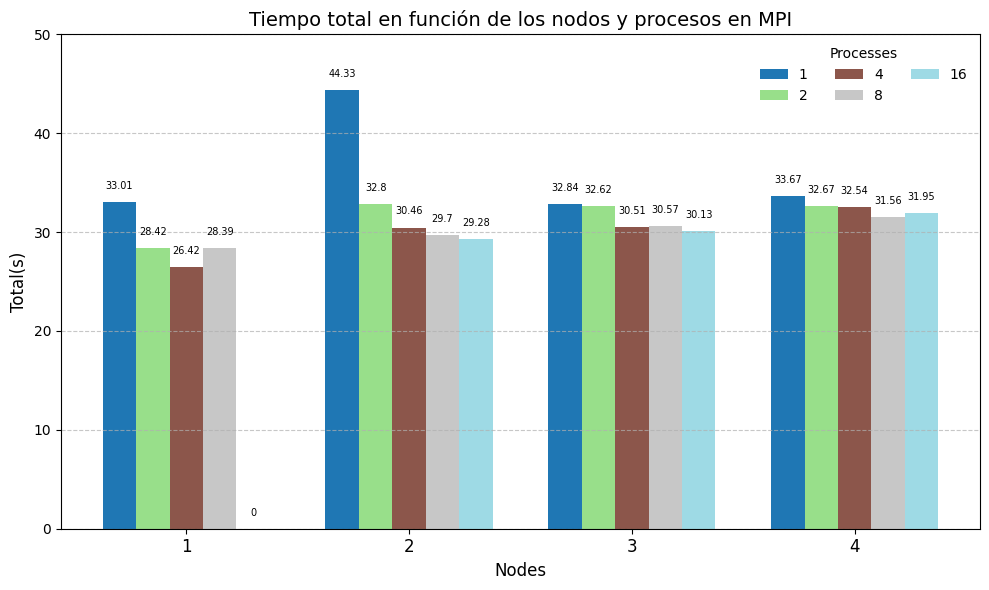

In [9]:
draw_grouped_bar_chart(mpi_data, "Nodes", "Processes", "Total(s)", 'Tiempo total en función de los nodos y procesos en MPI')

## OpenMP

En esta sección se generan las gráficas para el análisis de resultados de OpenMP.

9


<Figure size 500x500 with 0 Axes>

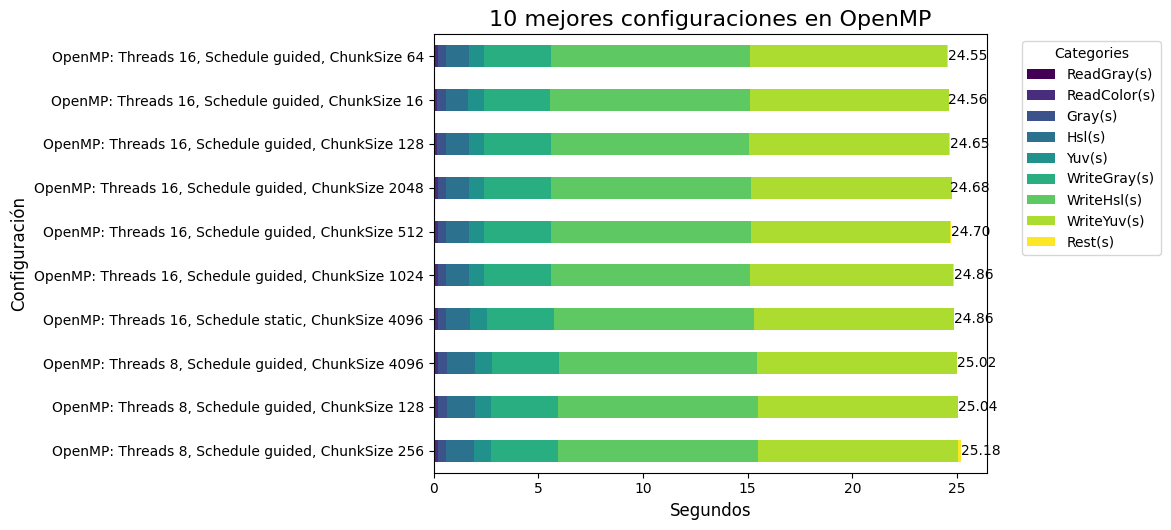

In [10]:
show_accumulative_plot(openmp_data, '10 mejores configuraciones en OpenMP', True)

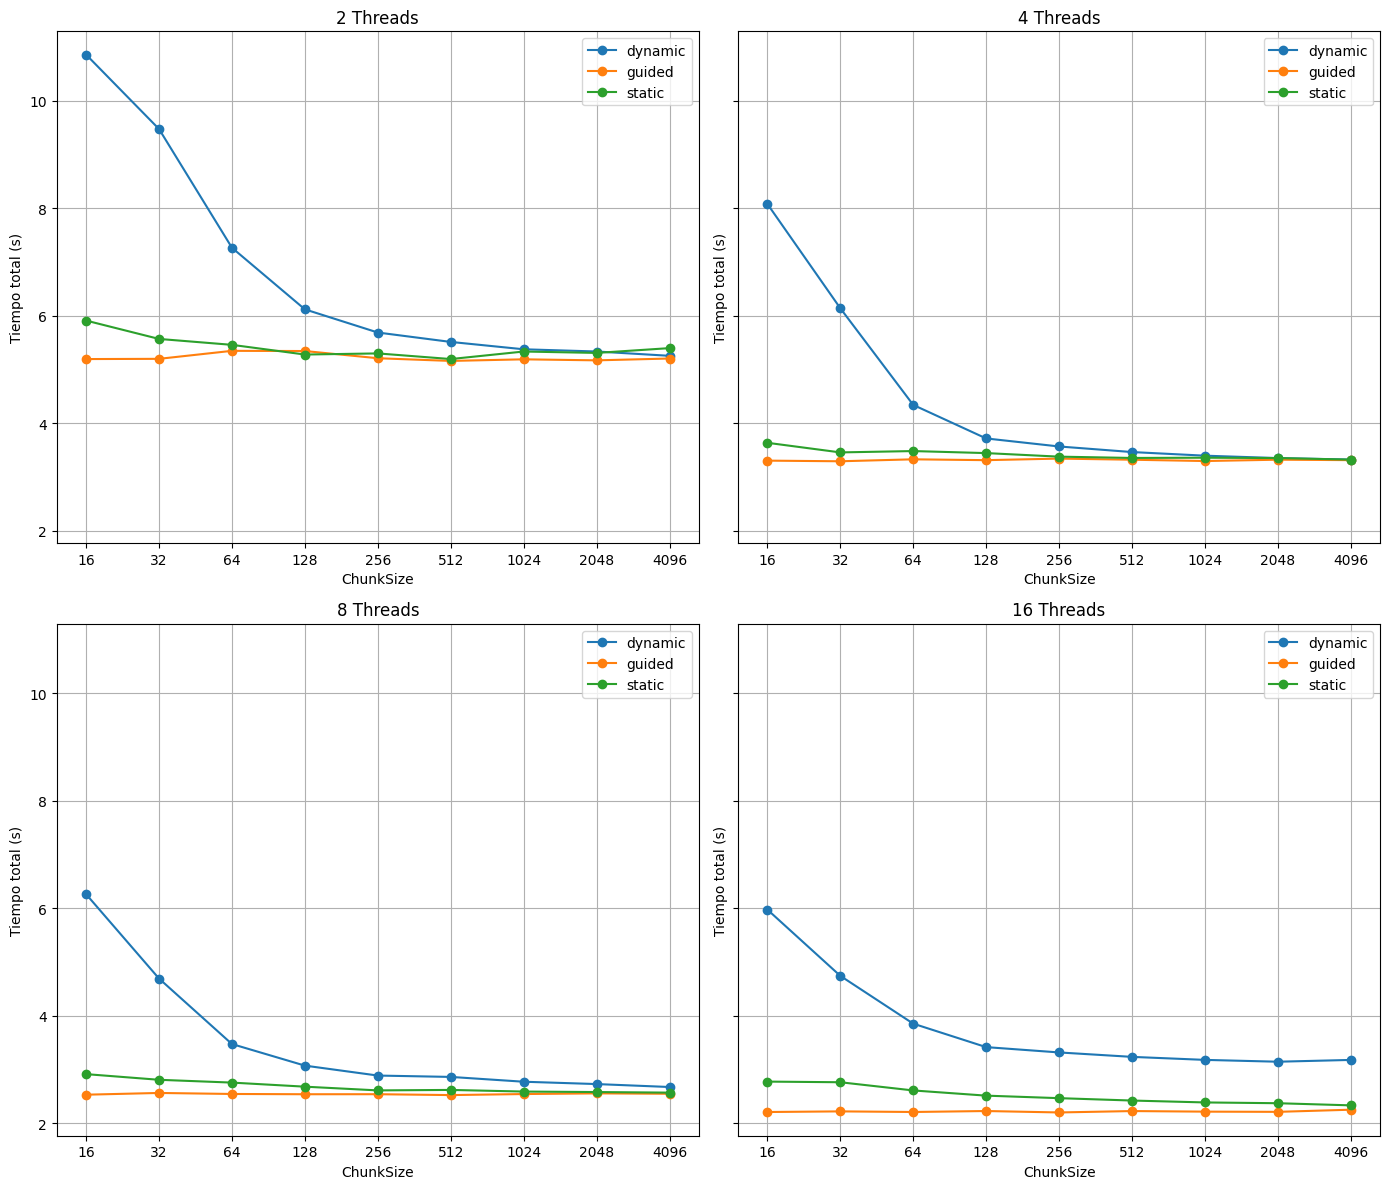

In [11]:
# Crear una función para graficar los datos
def plot_schedule_data(ax, data, title):
    data = data.copy()
    data['TotalParallel(s)'] = data['Gray(s)'] + data['Hsl(s)'] + data['Yuv(s)']
    for schedule_type in data['Schedule'].unique():
        subset = data[data['Schedule'] == schedule_type]
        ax.plot(subset['ChunkSize'], subset['TotalParallel(s)'], marker='o', label=schedule_type)
    ax.set_title(title)
    ax.set_xlabel('ChunkSize')
    ax.set_ylabel('Tiempo total (s)')
    ax.legend()
    ax.grid(True)
    ax.set_xscale('log', base=2)
    ax.set_xticks([16, 32, 64, 128, 256, 512, 1024, 2048, 4096])
    ax.set_xticklabels([16, 32, 64, 128, 256, 512, 1024, 2048, 4096])

# Filtrar los datos para los hilos 2, 4, 8 y 16
data_2_threads = openmp_data[openmp_data['Num Threads'] == 2]
data_4_threads = openmp_data[openmp_data['Num Threads'] == 4]
data_8_threads = openmp_data[openmp_data['Num Threads'] == 8]
data_16_threads = openmp_data[openmp_data['Num Threads'] == 16]

# Crear subplots en una cuadricula de 2x2
fig, axes = plt.subplots(2, 2, figsize=(14, 12), sharey=True)

# Graficar para 2, 4, 8 y 16 hilos
plot_schedule_data(axes[0, 0], data_2_threads, '2 Threads')
plot_schedule_data(axes[0, 1], data_4_threads, '4 Threads')
plot_schedule_data(axes[1, 0], data_8_threads, '8 Threads')
plot_schedule_data(axes[1, 1], data_16_threads, '16 Threads')

# Ajustar diseño
plt.tight_layout()

# Guardar la figura
plt.savefig('results_assets/figures/Tiempo total en las distintas configuraciones de Schedule en función del número de hilos y el tamaño del chunk en OpenMP.png')

plt.show()


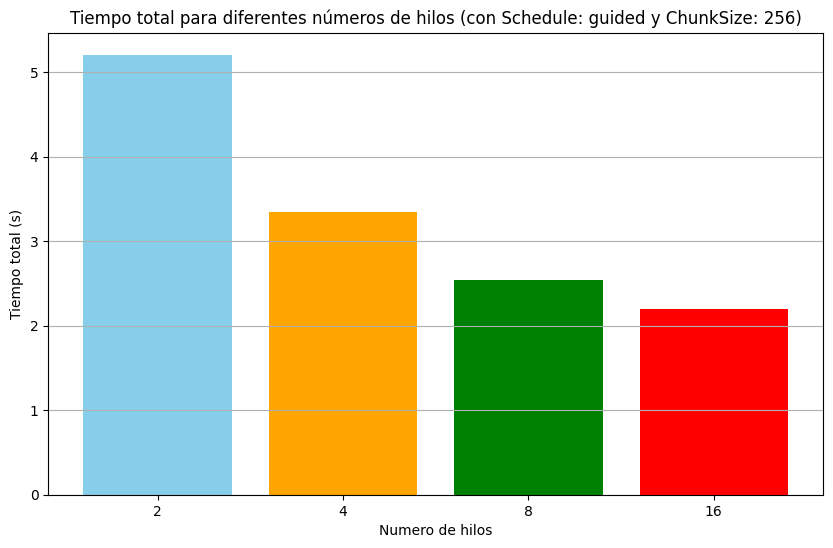

In [12]:
# Filtrar los datos para el schedule guided y chunksize 256
filtered_data = openmp_data[(openmp_data['Schedule'] == 'guided') & (openmp_data['ChunkSize'] == 256)].copy()

# Calcular el nuevo tiempo total
filtered_data.loc[:, 'Total Time (s)'] = filtered_data['Gray(s)'] + filtered_data['Hsl(s)'] + filtered_data['Yuv(s)']

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
colors = ['skyblue', 'orange', 'green', 'red']
plt.bar(range(len(filtered_data['Num Threads'])), filtered_data['Total Time (s)'], color=colors)
plt.xlabel('Numero de hilos')
plt.ylabel('Tiempo total (s)')
plt.title('Tiempo total para diferentes números de hilos (con Schedule: guided y ChunkSize: 256)')

plt.xticks(range(len(filtered_data['Num Threads'])), filtered_data['Num Threads'])
plt.grid(axis='y')

# Mostrar el gráfico
plt.show()

## MPI + OpenMP

En esta sección se generan las gráficas para el análisis de resultados de MPI + OpenMP.

9


<Figure size 500x500 with 0 Axes>

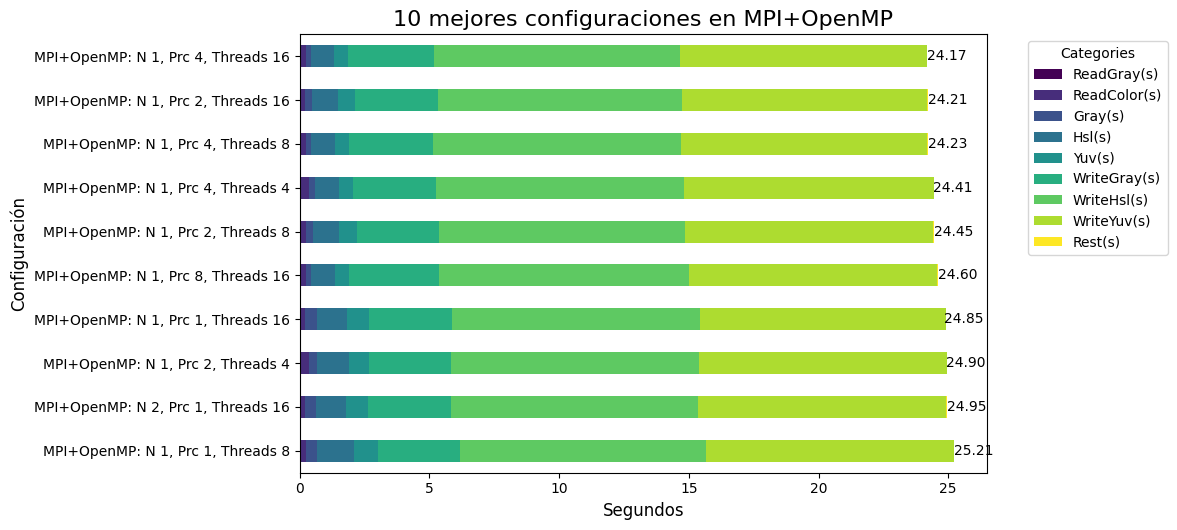

In [13]:
show_accumulative_plot(mpi_openmp_data, '10 mejores configuraciones en MPI+OpenMP', True)

/tmp/ipykernel_22072/2972201992.py:88: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  value = float(node_data[node_data[column2]==p][column3])
/tmp/ipykernel_22072/2972201992.py:123: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


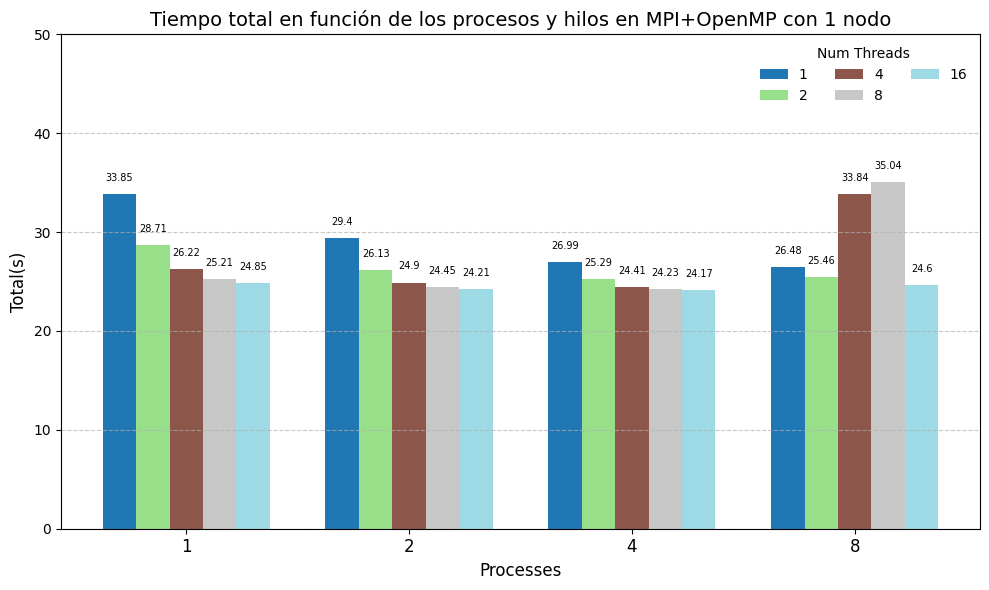

In [14]:
data = mpi_openmp_data[mpi_openmp_data["Nodes"] == 1]
draw_grouped_bar_chart(data, "Processes", "Num Threads", "Total(s)", 'Tiempo total en función de los procesos y hilos en MPI+OpenMP con 1 nodo')

/tmp/ipykernel_22072/2972201992.py:88: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  value = float(node_data[node_data[column2]==p][column3])


/tmp/ipykernel_22072/2972201992.py:123: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


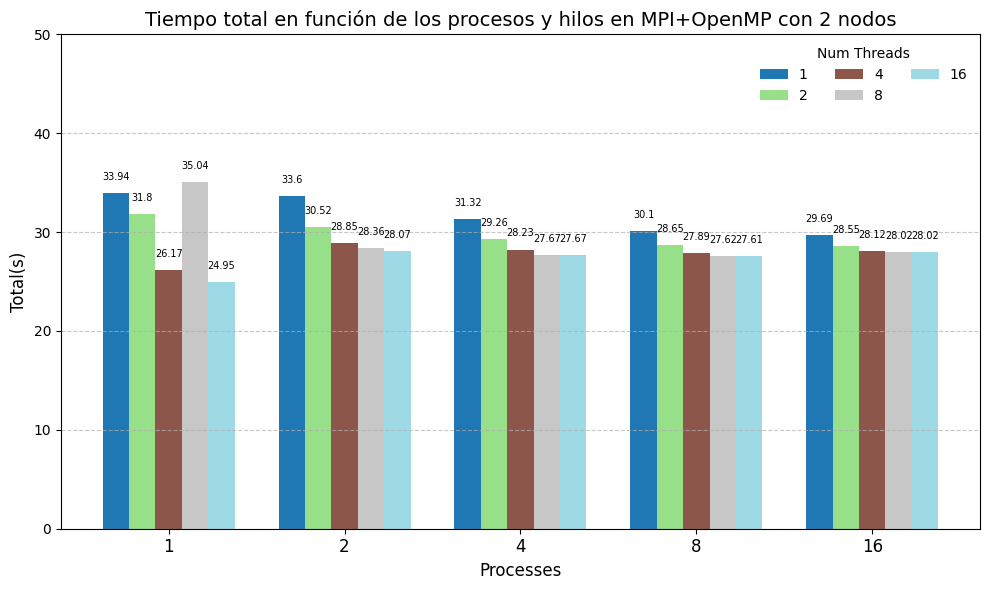

In [15]:
data = mpi_openmp_data[mpi_openmp_data["Nodes"] == 2]
draw_grouped_bar_chart(data, "Processes", "Num Threads", "Total(s)", 'Tiempo total en función de los procesos y hilos en MPI+OpenMP con 2 nodos')